In [1]:
import sys

sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")

import os
import warnings
from dataclasses import dataclass
from pathlib import Path

import agasc
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from chandra_aca import star_probs
from chandra_aca.star_probs import acq_success_prob, binomial_confidence_interval

from utils_stats import get_acq_stats_data

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
os.environ["CHANDRA_MODELS_DEFAULT_VERSION"] = "acq-model-2024-09"

In [3]:
star_probs.get_default_acq_prob_model_info()

{'default_model': 'grid-*',
 'call_args': {'file_path': 'chandra_models/aca_acq_prob',
  'version': None,
  'repo_path': 'None',
  'require_latest_version': False,
  'timeout': 5,
  'read_func': '<function _read_grid_func_model at 0x169abd300>',
  'read_func_kwargs': {'model_name': 'grid-*'}},
 'version': 'acq-model-2024-09',
 'commit': '55375feca820c76b92d1f2b2d5ecb842df6f5739',
 'data_file_path': '/var/folders/0p/mj5zm2311gl283lksrknl7bc0000gp/T/tmpilogkb9f/chandra_models/aca_acq_prob/grid-local-quadratic-2024-09.fits.gz',
 'repo_path': '/Users/aldcroft/ska/data/chandra_models',
 'md5': '7252f5faaeb14509d93b1ccc606c64d3',
 'CHANDRA_MODELS_REPO_DIR': None,
 'CHANDRA_MODELS_DEFAULT_VERSION': 'acq-model-2024-09',
 'THERMAL_MODELS_DIR_FOR_MATLAB_TOOLS_SW': None}

In [4]:
# Disable UserWarning: Model grid-local-quadratic-2023-05.fits.gz computed between
warnings.filterwarnings("ignore", r"\nModel", UserWarning)

In [5]:
# Read flight acquisition stats data and remove color=1.5 stars that have a different
# acquisition model due to a different mag error distribution.
data = get_acq_stats_data()

In [6]:
agasc_file = "agasc*"
stars = agasc.get_stars(
    data["agasc_id"], use_supplement=True, agasc_file=str(agasc_file)
)
data["mag_aca"] = stars["MAG_ACA"]

In [7]:
data["fail"] = ~data["obc_id"]

In [8]:
data.info

<Table length=78552>
     name       dtype 
-------------- -------
        tstart float64
         obsid   int64
        obc_id    bool
     halfwidth   int64
       mag_aca float32
       mag_obs float64
         color float32
      img_func  bytes7
       ion_rad    bool
       sat_pix    bool
      agasc_id   int64
         t_ccd float64
          slot   int64
      star_mag float32
search_success    bool
 search_box_hw   int64
      ccd_temp float64
         ObsID   int64
     mag_catid    bool
          year float32
       quarter float32
          fail    bool

In [9]:
def plot_fails_mag_aca_vs_t_ccd(data, year0=2015.0):
    ok = (data["year"] > year0) & ~data["fail"].astype(bool)
    da = data[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da["t_ccd"] + fuzzx, da["mag_aca"] + fuzzy, ".C0", markersize=4)

    ok = (data["year"] > year0) & data["fail"].astype(bool)
    da = data[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da["t_ccd"] + fuzzx, da["mag_aca"] + fuzzy, ".C1", markersize=4, alpha=0.8)

    # plt.xlim(-18, -10)
    # plt.ylim(7.0, 11.1)
    x0, x1 = -16, 3
    plt.xlim(x0, x1)
    plt.xlabel("T_ccd (C)")
    plt.ylabel("Mag_aca")
    plt.title(f"Acq successes (blue) and failures (orange) since {year0}")
    plt.grid(True)

In [10]:
def plot_acqs_mag_aca_vs_t_ccd(data):
    plt.figure(figsize=(8, 8))
    for subplot, halfwidth in enumerate([60, 80, 100, 120, 140, 160]):
        plt.subplot(3, 2, subplot + 1)
        ok = (data["halfwidth"] > halfwidth - 10) & (
            data["halfwidth"] <= halfwidth + 10
        )
        plot_fails_mag_aca_vs_t_ccd(data[ok], year0=2023.5)
        plt.title(f"Acq success (blue) fail (red)\nbox={halfwidth}")
        plt.xlim(-15, 0)
        plt.ylim(5.0, 12.0)
    plt.tight_layout()

### Plot acq `mag_aca` vs `t_ccd` distribution per search box size

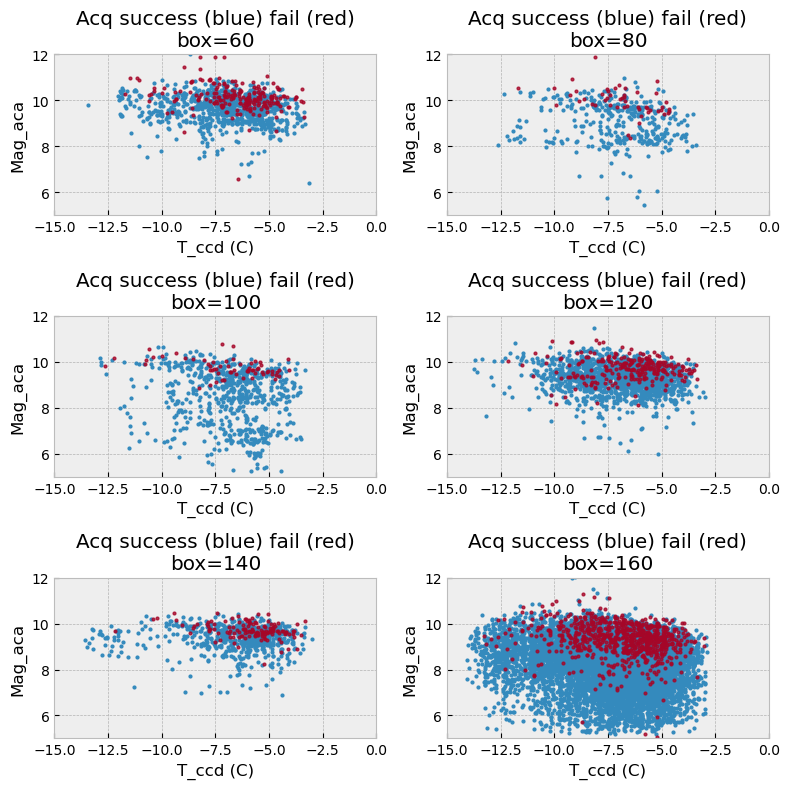

In [11]:
plot_acqs_mag_aca_vs_t_ccd(data)

In [12]:
@dataclass
class ProbFail:
    p_fail: float
    p_fail_lower: float
    p_fail_upper: float
    mean_t_ccd: float
    mean_mag: float
    n_fail: int
    n_acq: int
    t_ccd_err_lo: float
    t_ccd_err_hi: float
    p_fail_model: float

In [13]:
def calc_binned_pfail(data, mag0, mag1, t_ccd0, t_ccd1, halfwidth=None):
    fail = data["fail"].astype(bool)
    ok = (
        (data["mag_aca"] >= mag0)
        & (data["mag_aca"] < mag1)
        & (data["t_ccd"] >= t_ccd0)
        & (data["t_ccd"] < t_ccd1)
    )
    if halfwidth is not None:
        ok &= data["halfwidth"] == halfwidth

    n_fail = np.count_nonzero(fail[ok])
    n_acq = np.count_nonzero(ok)
    if n_acq < 15:
        return None

    p_succs_model = acq_success_prob(
        mag=data["mag_aca"][ok],
        t_ccd=data["t_ccd"][ok],
        halfwidth=data["halfwidth"][ok],
    )
    # 1.5% chance of IR => failure each time. Probability of successful acq is the model
    # success * Probability of NOT IR = p_succ * (1 - 0.015).
    p_fail_model = 1 - np.mean(p_succs_model * 0.985)
    p_fail = n_fail / n_acq
    _, p_fail_lower, p_fail_upper = binomial_confidence_interval(n_fail, n_acq)
    # Ensure that error bars are >= 0. We will want to plot p_fail as n_fail/n_acq,
    # instead of (e.g.) p_fail = 50th percentile.
    p_fail_lower = min(p_fail, p_fail_lower)
    p_fail_upper = max(p_fail, p_fail_upper)
    mean_t_ccd = np.mean(data["t_ccd"][ok])
    mean_mag = np.mean(data["mag_aca"][ok])
    out = ProbFail(
        p_fail,
        p_fail_lower,
        p_fail_upper,
        mean_t_ccd,
        mean_mag,
        n_fail,
        n_acq,
        t_ccd_err_hi=t_ccd1 - mean_t_ccd,
        t_ccd_err_lo=mean_t_ccd - t_ccd0,
        p_fail_model=p_fail_model,
    )
    return out

In [14]:
# MAG_VALS = [8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75]
# MAG_BINS = [7.5, 8.5, 9.25, 9.625, 9.875, 10.125, 10.375, 10.625, 11.25]
# These match the ACA mag bins used in the model grid
MAG_VALS = [9.0, 9.5, 10.0, 10.5]
MAG_BINS = [8.75, 9.25, 9.75, 10.25, 10.75]

In [15]:
# These match the T_ccd bins used in the model grid
T_CCD_VALS = np.array([-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2])
T_CCD_BINS = [
    -15.5,
    -14.0,
    -12.0,
    -10.0,
    -8.5,
    -7.5,
    -6.5,
    -5.5,
    -4.5,
    -3.5,
    -2.5,
    -1.0,
    1.0,
    2.5,
]

In [16]:
1 - acq_success_prob(mag=10.0, t_ccd=-7, halfwidth=120)

0.2865907334341664

In [17]:
calc_binned_pfail(data, mag0=9.75, mag1=10.25, t_ccd0=-7.5, t_ccd1=-6.5, halfwidth=120)

ProbFail(p_fail=0.2755905511811024, p_fail_lower=0.23783066220262053, p_fail_upper=0.3168681797573234, mean_t_ccd=-6.93731688326738, mean_mag=9.93828, n_fail=35, n_acq=127, t_ccd_err_lo=0.5626831167326198, t_ccd_err_hi=0.43731688326738016, p_fail_model=0.27772043819570924)

In [18]:
def get_binned_pfails(
    data, halfwidth=None, year_min=None, print_vals=True
) -> list[list[ProbFail]]:
    pfs_list = []
    if year_min is not None:
        data = data[data["year"] > year_min]
    for mag, mag0, mag1 in zip(MAG_VALS, MAG_BINS[:-1], MAG_BINS[1:]):
        pfs = []
        for t_ccd, t_ccd0, t_ccd1 in zip(T_CCD_VALS, T_CCD_BINS[:-1], T_CCD_BINS[1:]):
            pf = calc_binned_pfail(
                data, mag0, mag1, t_ccd0, t_ccd1, halfwidth=halfwidth
            )
            if pf is not None:
                pfs.append(pf)
                if print_vals:
                    print(
                        f"mag={mag} mean_mag_aca={pf.mean_mag:.2f} "
                        f"t_ccd={t_ccd} t_ccd_mean={pf.mean_t_ccd:.2f} "
                        f"p_fail={pf.n_fail}/{pf.n_acq}={pf.p_fail:.2f}"
                    )
        pfs_list.append(pfs)
    return pfs_list

In [19]:
def _plot_flight_model_and_data(color, pfs_list: list[list[ProbFail]], halfwidth=160):
    # This computes probabilities for 160 arcsec boxes, corresponding to raw data
    t_ccds = np.linspace(-14, -2, 20)

    if halfwidth is not None:
        for ii, mag_aca in enumerate(MAG_VALS):
            p_succ_model = acq_success_prob(
                date="2024-02-01T00:00:00",
                t_ccd=t_ccds,
                mag=mag_aca,
                color=color,
                halfwidth=halfwidth,
            )
            p_fail_flight = (
                1 - p_succ_model * 0.985
            )  # See calc_binned_pfail for this factor
            plt.plot(
                t_ccds, p_fail_flight, "-", color=f"C{ii}", label=f"mag_aca={mag_aca}"
            )

    # pf1, pf2 have p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag_aca, n_fail, n_acq
    for ii, pfs in enumerate(pfs_list):
        clr = f"C{ii}"
        for pf in pfs:
            yerr = np.array(
                [pf.p_fail - pf.p_fail_lower, pf.p_fail_upper - pf.p_fail]
            ).reshape(2, 1)
            plt.errorbar(
                pf.mean_t_ccd,
                pf.p_fail,
                xerr=np.array([pf.t_ccd_err_lo, pf.t_ccd_err_hi]).reshape(2, 1),
                yerr=yerr,
                color=clr,
                marker="o",
                alpha=0.6,
            )
        if halfwidth is None:
            x = [pf.mean_t_ccd for pf in pfs]
            y = [pf.p_fail_model for pf in pfs]
            plt.plot(x, y, color=clr, linestyle="-", label=f"model mag={MAG_VALS[ii]}")

    # plt.xlim(-16, None)
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(-14, 2)
    plt.xlabel("T_ccd")
    plt.ylabel("P_fail")
    plt.title(f"P_fail flight model and data (halfw={halfwidth})")
    plt.grid(True)

In [20]:
def plot_flight_model_and_data(flt, halfwidth=160, print_vals=True, year_min=None):
    pfails_list = get_binned_pfails(
        flt, halfwidth=halfwidth, year_min=year_min, print_vals=print_vals
    )
    _plot_flight_model_and_data(color=1.0, pfs_list=pfails_list, halfwidth=halfwidth)
    plt.title(f"P_fail model and data after {year_min} (halfw={halfwidth})")

### Compare to flight data after 2019.5 for specified search box sizes

/Users/aldcroft/miniconda3-arm/envs/ska3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:696: RuntimeWarning: invalid value encountered in _beta_isf
  return _boost._beta_isf(x, a, b)


mag=9.0 mean_mag_aca=9.03 t_ccd=-11 t_ccd_mean=-10.84 p_fail=1/46=0.02
mag=9.0 mean_mag_aca=9.03 t_ccd=-9 t_ccd_mean=-9.23 p_fail=6/121=0.05
mag=9.0 mean_mag_aca=9.04 t_ccd=-8 t_ccd_mean=-8.02 p_fail=13/137=0.09
mag=9.0 mean_mag_aca=9.00 t_ccd=-7 t_ccd_mean=-6.89 p_fail=8/144=0.06
mag=9.0 mean_mag_aca=9.01 t_ccd=-6 t_ccd_mean=-6.03 p_fail=4/112=0.04
mag=9.0 mean_mag_aca=9.01 t_ccd=-5 t_ccd_mean=-5.15 p_fail=6/109=0.06
mag=9.0 mean_mag_aca=9.03 t_ccd=-4 t_ccd_mean=-4.19 p_fail=2/30=0.07
mag=9.5 mean_mag_aca=9.55 t_ccd=-13 t_ccd_mean=-12.57 p_fail=0/18=0.00
mag=9.5 mean_mag_aca=9.54 t_ccd=-11 t_ccd_mean=-10.81 p_fail=11/98=0.11
mag=9.5 mean_mag_aca=9.50 t_ccd=-9 t_ccd_mean=-9.23 p_fail=26/261=0.10
mag=9.5 mean_mag_aca=9.51 t_ccd=-8 t_ccd_mean=-8.05 p_fail=23/246=0.09
mag=9.5 mean_mag_aca=9.51 t_ccd=-7 t_ccd_mean=-6.91 p_fail=32/230=0.14
mag=9.5 mean_mag_aca=9.49 t_ccd=-6 t_ccd_mean=-6.01 p_fail=31/185=0.17
mag=9.5 mean_mag_aca=9.47 t_ccd=-5 t_ccd_mean=-5.15 p_fail=20/141=0.14
mag=9.5 mea

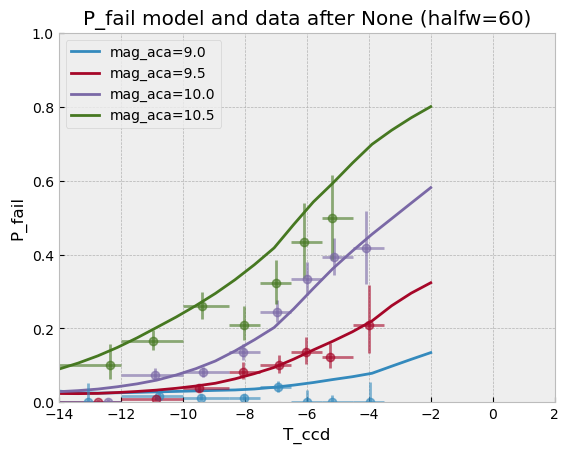

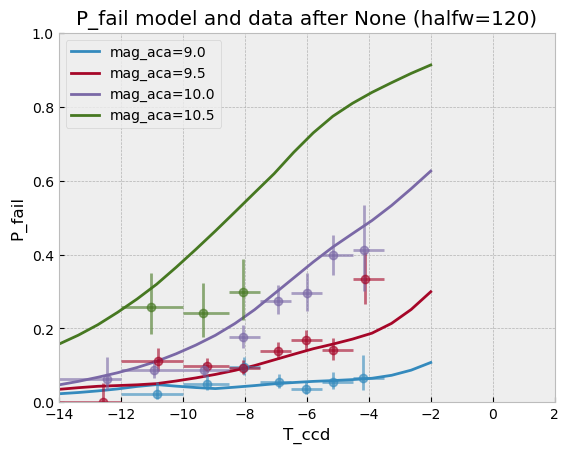

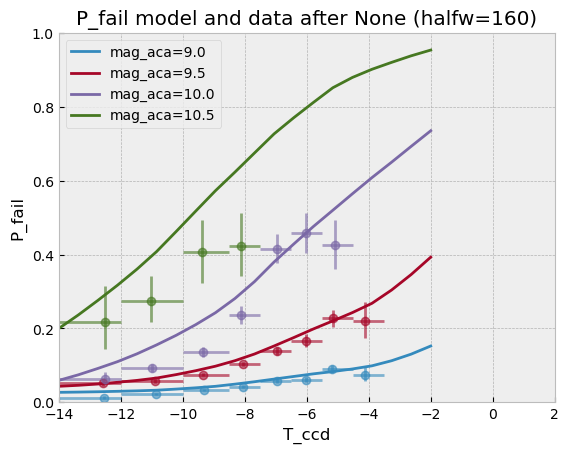

In [21]:
plot_flight_model_and_data(data, halfwidth=60, print_vals=False)
plt.figure()
plot_flight_model_and_data(data, halfwidth=120, print_vals=True)
plt.figure()
plot_flight_model_and_data(data, halfwidth=160, print_vals=False)

### Compare to flight data after 2019.5 integrating over search box sizes

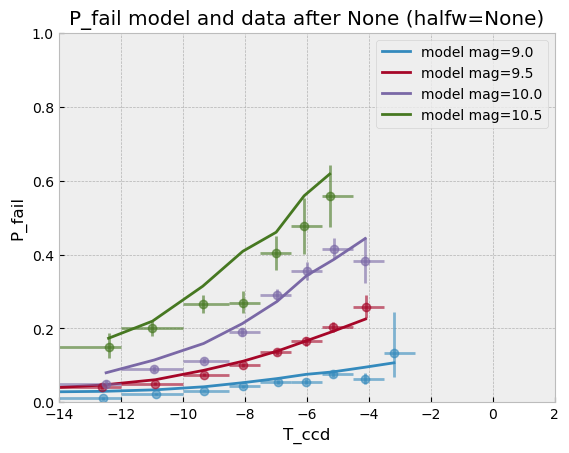

In [22]:
# In this plot there is no filtering on halfwidth. The model prediction is
# the mean of the model prediction for each data point in the bin.
plot_flight_model_and_data(data, halfwidth=None, print_vals=False)

### Compare to flight data after 2023.5

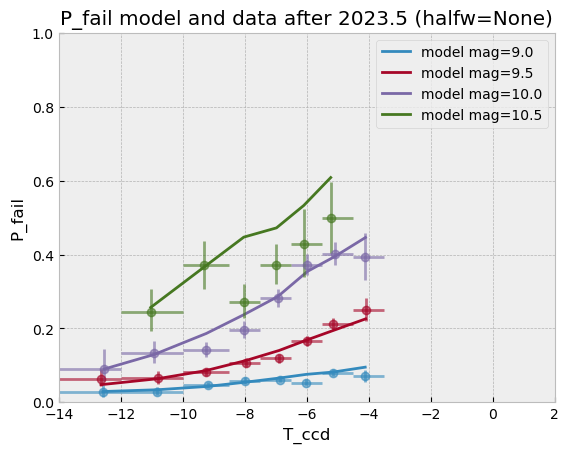

In [23]:
plot_flight_model_and_data(data, halfwidth=None, print_vals=False, year_min=2023.5)

mag=9.0 mean_mag_aca=9.05 t_ccd=-9 t_ccd_mean=-9.37 p_fail=0/15=0.00
mag=9.0 mean_mag_aca=8.98 t_ccd=-8 t_ccd_mean=-7.99 p_fail=0/20=0.00
mag=9.0 mean_mag_aca=9.07 t_ccd=-7 t_ccd_mean=-6.86 p_fail=0/31=0.00
mag=9.0 mean_mag_aca=9.09 t_ccd=-6 t_ccd_mean=-5.96 p_fail=0/17=0.00
mag=9.0 mean_mag_aca=9.06 t_ccd=-5 t_ccd_mean=-5.18 p_fail=0/40=0.00
mag=9.0 mean_mag_aca=9.03 t_ccd=-4 t_ccd_mean=-3.92 p_fail=0/15=0.00
mag=9.5 mean_mag_aca=9.47 t_ccd=-11 t_ccd_mean=-10.63 p_fail=0/15=0.00
mag=9.5 mean_mag_aca=9.48 t_ccd=-9 t_ccd_mean=-9.53 p_fail=2/33=0.06
mag=9.5 mean_mag_aca=9.53 t_ccd=-8 t_ccd_mean=-7.97 p_fail=2/37=0.05
mag=9.5 mean_mag_aca=9.49 t_ccd=-7 t_ccd_mean=-6.90 p_fail=8/67=0.12
mag=9.5 mean_mag_aca=9.54 t_ccd=-6 t_ccd_mean=-5.98 p_fail=9/55=0.16
mag=9.5 mean_mag_aca=9.53 t_ccd=-5 t_ccd_mean=-5.30 p_fail=9/69=0.13
mag=9.5 mean_mag_aca=9.50 t_ccd=-4 t_ccd_mean=-3.97 p_fail=3/15=0.20
mag=10.0 mean_mag_aca=10.02 t_ccd=-11 t_ccd_mean=-11.07 p_fail=2/20=0.10
mag=10.0 mean_mag_aca=10.02 

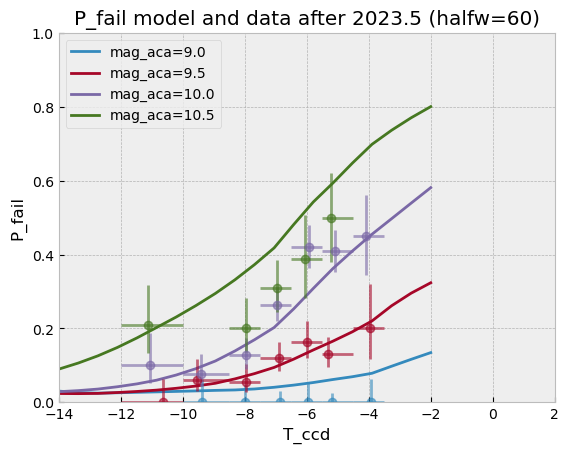

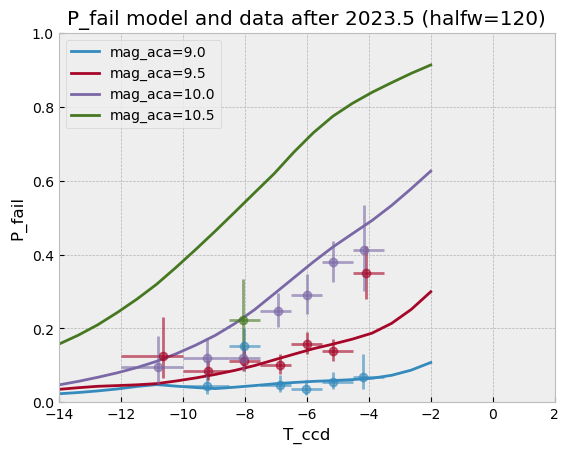

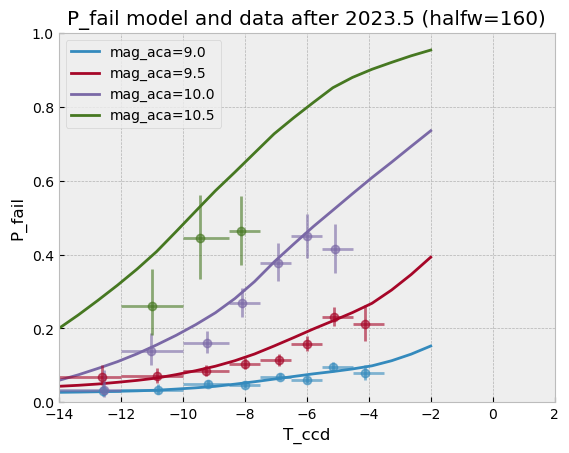

In [24]:
plot_flight_model_and_data(data, halfwidth=60, print_vals=True, year_min=2023.5)
plt.figure()
plot_flight_model_and_data(data, halfwidth=120, print_vals=True, year_min=2023.5)
plt.figure()
plot_flight_model_and_data(data, halfwidth=160, print_vals=False, year_min=2023.5)

In [25]:
# Is the excess at -4C and 120 halfw due to a small number of stars?  NO.
mag0, mag1 = 9.25, 9.625
t_ccd0, t_ccd1 = -4.5, -3.5
halfwidth = 120
ok = (
    (data["mag_aca"] >= mag0)
    & (data["mag_aca"] < mag1)
    & (data["t_ccd"] >= t_ccd0)
    & (data["t_ccd"] < t_ccd1)
    & (data["halfwidth"] == halfwidth)
)
fok = data[ok]
print(len(set(fok["agasc_id"])))
print(len(fok))
fok["t_ccd"].format = ".2f"
fok["year"].format = ".2f"

33
38


In [26]:
fok[
    "obsid",
    "t_ccd",
    "year",
    "agasc_id",
    "mag_aca",
    "mag_obs",
    "fail",
    "img_func",
    "ion_rad",
].pprint_all()

obsid t_ccd   year   agasc_id  mag_aca  mag_obs  fail img_func ion_rad
----- ----- ------- ---------- -------- ------- ----- -------- -------
26763 -4.34 2022.98  446960848 9.404025  9.4375 False     star   False
26848 -4.34 2023.59     138632 9.408578   9.125 False     star   False
27365 -4.34 2023.71   78911104 9.439248   9.125 False     star   False
26950 -3.97 2023.85 1110576952 9.527108  9.9375  True  spoiler   False
43938 -4.34 2023.91  166470016  9.25787  8.9375 False     star   False
28072 -4.34 2023.95  208941360 9.470705     9.0 False     star   False
28199 -3.97 2024.03  576337024 9.442167  8.8125 False     star   False
43802 -3.97 2024.03  439225336 9.263555  8.9375 False     star   False
43800 -4.34 2024.03  439225336 9.263555    9.75  True  spoiler   False
43795 -3.90 2024.04  249567416 9.330288    8.75 False     star   False
43795 -3.90 2024.04  249562744  9.40937     0.0  True     NONE   False
26725 -4.34 2024.06  453528400 9.415082     9.0 False     star   False
26679 